<a href="https://colab.research.google.com/github/maurofama99/ann_challenge/blob/main/final_model_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#ANNDL Challenge 1

##Set Up

Connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


Go inside the folder

In [ ]:
%cd /gdrive/My Drive/

/gdrive/My Drive


Import libraries

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn import svm
from PIL import Image

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


Seed for reproducivity

In [ ]:
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

Suppress warnings

In [ ]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Funtions to test the model on validation set and plot the confusion matrix

In [ ]:
def plot_confusionMatrix(test_labels, test_predicted):
  
  cm = confusion_matrix(test_labels, test_predicted, labels=[0,1,2,3,4,5,6,7])
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                display_labels=labels)
  disp.plot()
  plt.show()
  return 

In [ ]:
def testModel( valid_gen, model):

  # Predit test labels
  test_predicted = model.predict(valid_gen)
  test_predicted = np.argmax(test_predicted, axis=-1)
  
  # plot confusion matrix
  plot_confusionMatrix(valid_gen.classes, test_predicted)

  # display classification results
  print(classification_report(valid_gen.classes, test_predicted, target_names=labels))

In [ ]:
# Dataset folders 
dataset_dir = 'training_data_final'

In [ ]:
#get the number of img of each species
import fnmatch

count = [0,0,0,0,0,0,0,0]   # where I store the amount of images for each species
labels = ['Species1',       # 0
          'Species2',       # 1
          'Species3',       # 2
          'Species4',       # 3
          'Species5',       # 4
          'Species6',       # 5
          'Species7',       # 6
          'Species8']       # 7

for i in range(len(labels)):
  dir_path = os.path.join(dataset_dir, labels[i])
  count[i] = len(fnmatch.filter(os.listdir(dir_path), '*.*'))
  print('The number of img of', labels[i], 'is: ', count[i])

cumsum = np.cumsum(count)
print('Total amount of img is: ', cumsum[len(cumsum)-1] )

The number of img of Species1 is:  186
The number of img of Species2 is:  532
The number of img of Species3 is:  515
The number of img of Species4 is:  511
The number of img of Species5 is:  531
The number of img of Species6 is:  222
The number of img of Species7 is:  537
The number of img of Species8 is:  508
Total amount of img is:  3542


Inspect the data

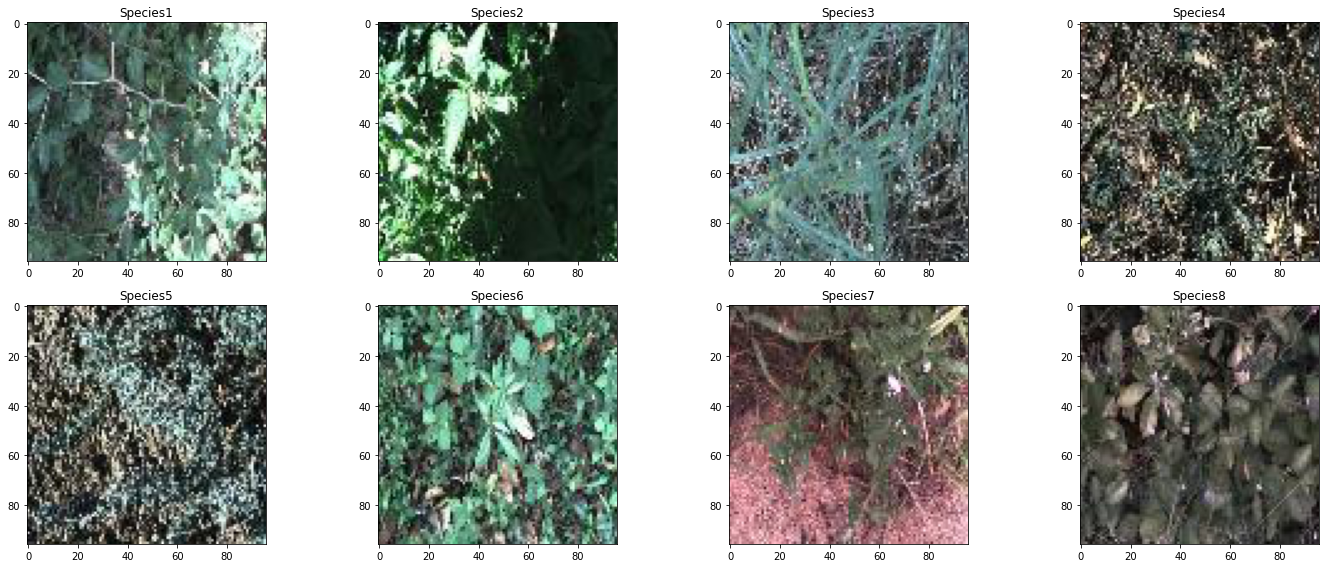

In [ ]:
import matplotlib.image as mpimg
num_row = 2
num_col = 4
fig,axes = plt.subplots(num_row, num_col, figsize=(10*num_row,2*num_col))
i = 0

for label in labels:
  path = dataset_dir +"/"+ label +"/00005.jpg"
  image = mpimg.imread(path)
  ax = axes[i//num_col, i%num_col]
  ax.imshow(image)
  ax.set_title(label)
  i=i+1

plt.tight_layout()
plt.show()

From the following graph we can see the distribution of the images with respect to the classes. It's possible to notice that especially the classes "Species1" and "Species6" contain few images with respect to the other. To perform the training of the network is better to have a balanced dataset. For this reason we want to have the classifier heavily weight the few examples that are available. We'll do this by passing Keras weights for each class through the "class_weight" parameter.

Text(0.5, 1.0, 'Images per class')

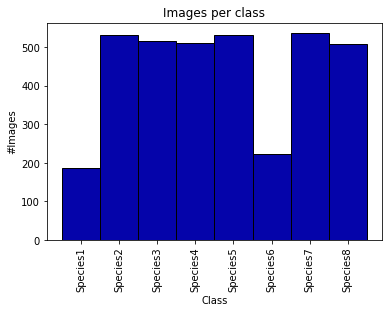

In [ ]:
n_bins = 8
n, bins, patches = plt.hist(x=dataset.classes, color='#0504aa', bins = n_bins, align ='right', edgecolor = 'black')
ticks = [(patch._x0 + patch._x1)/2 for patch in patches]
ticklabels = [label for label in labels]
plt.xticks(ticks, ticklabels, rotation = 'vertical')

plt.xlabel('Class')
plt.ylabel('#Images')
plt.title('Images per class')

###Split data in train and test
Split the dataset in train (80%) and validation (20%) \\
Also apply as augmentations: 
- rotation (30)
- shift (50)
- zoom (0.3)
- horizontal flip
- vertical flip

In [ ]:
# Images are divided into folders, one for each class. 
# If the images are organized in such a way, we can exploit the ImageDataGenerator to read them from disk.
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator with Data Augmentation
valid_data_gen = ImageDataGenerator(rescale=1/255, validation_split=0.2) 

train_data_gen = ImageDataGenerator(rotation_range=30,
                                        height_shift_range=50,
                                        width_shift_range=50,
                                        zoom_range=0.3,
                                        horizontal_flip=True,
                                        vertical_flip=True, 
                                        fill_mode='reflect',
                                        rescale=1/255,
                                        validation_split=0.2)

# Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
train_gen = train_data_gen.flow_from_directory(directory=dataset_dir,
                                                           target_size=(96,96),
                                                           color_mode='rgb',
                                                           classes=None, 
                                                           class_mode='categorical',
                                                           batch_size=32,
                                                           shuffle=True,
                                                           seed=seed,
                                                           subset="training")

valid_gen = valid_data_gen.flow_from_directory(directory=dataset_dir,
                                               target_size=(96,96),
                                               color_mode='rgb',
                                               classes=None, 
                                               class_mode='categorical',
                                               batch_size=1,
                                               shuffle=False,
                                               seed=seed,
                                               subset="validation")

Found 2836 images belonging to 8 classes.
Found 706 images belonging to 8 classes.


In [ ]:
input_shape = (96, 96, 3)
epochs = 200

##Build Model

In [ ]:
def create_model_1(input_shape, convnet):

  dropout_rate = 0.2
  dropout_rate1 = 0.5

  # Build the model layer by layer
  input_layer = convnet.layers[0].input
  flat1 = Flatten()(convnet.layers[-1].output)
  flat1 = tfkl.Dropout(dropout_rate, seed=seed)(flat1)
  hidden_layer1 = tfkl.Dense(units=512, activation='relu', name='Hidden1', 
                                kernel_initializer=tfk.initializers.HeUniform(seed=seed))(flat1)
  hidden_layer1 = tfkl.Dropout(dropout_rate, seed=seed)(hidden_layer1)
  hidden_layer2 = tfkl.Dense(units=256, activation='relu', name='Hidden2', 
                                kernel_initializer=tfk.initializers.HeUniform(seed=seed))(hidden_layer1)
  hidden_layer2 = tfkl.Dropout(dropout_rate1, seed=seed)(hidden_layer2)
  output = tfkl.Dense(units=8, activation='softmax', name='Output', 
                                kernel_initializer=tfk.initializers.HeUniform(seed=seed))(hidden_layer2)
  
  # Connect input and output through the Model class
  model = tfk.Model(inputs=input_layer, outputs=output, name='model')

  # Compile the model
  learning_rate = 1e-5
  opt = tfk.optimizers.Adam(learning_rate)

  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=opt, metrics='accuracy')

  # Return the model
  return model

In [ ]:
def build_model_2(input_shape, supernet):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    xc_layer = supernet(input_layer) 

    flattening_layer = tfkl.Flatten(name='Flatten')(xc_layer)

    layer1 = tfkl.Dense(units=512, kernel_initializer = tfk.initializers.HeUniform(seed), activation='relu')(flattening_layer)

    dropout1 = tfkl.Dropout(0.2, seed=seed)(layer1)

    classifier_layer = tfkl.Dense(units=256, name='Classifier', kernel_initializer = tfk.initializers.HeUniform(seed), activation='relu')(dropout1)

    dropout2 = tfkl.Dropout(0.5, seed=seed)(classifier_layer)

    output_layer = tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dropout2)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-3), metrics='accuracy')

    # Return the model
    return model

In [ ]:
def build_model_3(input_shape, convnet):

  # Build the model
  input_layer = convnet.layers[0].input
  flat1 = Flatten()(convnet.layers[-1].output)
  hidden_layer1 = tfkl.Dense(units=700, activation='relu', name='Hidden1', 
                                kernel_initializer=tfk.initializers.HeUniform(seed=seed))(flat1)
  hidden_layer2 = tfkl.Dense(units=350, activation='relu', name='Hidden2', 
                                kernel_initializer=tfk.initializers.HeUniform(seed=seed))(hidden_layer1)
  output = tfkl.Dense(units=8, activation='softmax', name='Output', 
                                kernel_initializer=tfk.initializers.HeUniform(seed=seed))(hidden_layer2)
  
  # Connect input and output through the Model class
  model = tfk.Model(inputs=input_layer, outputs=output, name='model')

  
  # Compile the model
  learning_rate = 1e-4
  opt = tfk.optimizers.Adam(learning_rate)
  model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=opt, metrics='accuracy')
  
  # Return the model
  return model

###Callbacks

In [ ]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

##Model 1
VGG16 architecture

In [ ]:
from keras.applications.vgg16 import VGG16

vgg16 = VGG16(include_top=False, input_shape=inputshape)

Train all the layer, even the ones of the pre-trained model

In [ ]:
for layer in vgg16.layers:
	layer.trainable = True

In [ ]:
# Build model and visualize it
model_1 = build_model_1(input_shape, vgg16)
model_1.summary()

In [ ]:
# Create folders and callbacks and fit
callbacks = create_folders_and_callbacks(model_name='CNN_VGG16')

# Train the model
history = model_1.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

In [ ]:
# Save best epoch model
model_1.save("savedModels/CNN_VGG16")

In [ ]:
testModel(valid_gen, model_1)

##Model 2
XCeption architecture

In [ ]:
xCeption = tfk.applications.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)

Train only the fully connected layers (which are not part of the pre-trained model)

In [ ]:
for layer in xCeption.layers:
    layer.trainable = False

In [ ]:
model2 = build_model_2(input_shape, xCeption)
model2.summary()

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_XCeption')

# Train the model
history = model2.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

In [ ]:
# Save best epoch model
model2.save("savedModels/CNN_XCeption")

In [ ]:
testModel(valid_gen, model2)

Then perform Fine tuing by unfreezing the layers of the xception architecture and re train the hole model with a lower learning rate

In [ ]:
model_2 = tfk.models.load_model("savedModels/CNN_XCeption")

unfreeze the layers

In [ ]:
model_2.get_layer('xception').trainable = True

In [ ]:
model_2.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-4), metrics='accuracy')
model_2.summary()

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_XCeption_FineTuning')

# Train the model
history = model_2.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

In [ ]:
# Save best epoch model
model_2.save("savedModels/CNN_XCeption_FineTuning")

In [ ]:
testModel(valid_gen, model_2)

##Model 3
VGG19 architecture

In [ ]:
vgg19 = tfk.applications.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(96,96,3)
)

In [ ]:
for layer in vgg19.layers:
    layer.trainable = True

In [ ]:
model3 = build_model_3(input_shape, supernet9)
model3.summary()

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_VGG19')

# Train the model
history = model3.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

In [ ]:
# Save best epoch model
model3.save("savedModels/CNN_VGG19")

In [ ]:
testModel(valid_gen, model3)

Then perform Fine tuing by unfreezing the layers of the xception architecture and re train the hole model with a lower learning rate

In [ ]:
model_3 = tfk.models.load_model("savedModels/CNN_VGG19")

In [ ]:
model_3.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(1e-5), metrics='accuracy')
model_3.summary()

In [ ]:
callbacks = create_folders_and_callbacks(model_name='CNN_VGG19_FineTuning')

# Train the model
history = model_3.fit(
    x = train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    class_weight = {0: 3542/186, 1: 3542/532, 2: 3542/515, 3: 3542/511, 4: 3542/531, 
                    5: 3542/222, 6: 3542/537, 7: 3542/508},
    callbacks = callbacks,
).history

In [ ]:
# Save best epoch model
model_3.save("savedModels/CNN_VGG19_FineTuning")

In [ ]:
testModel(valid_gen, model_3)

##Ensamble
Combine together the tree models computing the avarage output

In [ ]:
first_model = tfk.models.load_model("savedModels/VGG16")
second_model = tfk.models.load_model("savedModels/CNN_XCeption_FineTuning")
third_model = tfk.models.load_model("savedModels/CNN_VGG19_FineTuning")

first_model._name = 'model1'
second_model._name = 'model2'
third_model._name = 'model3'

In [ ]:
models = [first_model, second_model, third_model]

model_input = tf.keras.Input(shape=input_shape, name='input_layer')
model_outputs = [model(model_input) for model in models]

ensemble_output = tf.keras.layers.Average()(model_outputs)

ensemble_model = tf.keras.Model(inputs=model_input, outputs=ensemble_output)

In [ ]:
ensemble_model.summary()

In [ ]:
ensemble_model.save("savedModels/EnsambleModel")

In [ ]:
testModel(valid_gen, ensemble_model)